# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

In [34]:
# torch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

# sklearn and skorch modules
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from skorch import NeuralNetRegressor,NeuralNetClassifier,callbacks
from skorch.dataset import CVSplit

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Regression task

## Dataset

In [35]:
class CsvDataset(Dataset):

    def __init__(self, csv_file):
        """
        Parameters:
            csv_file (string): Path to the csv file.

        """
        # store file inside a tensor object
        self.data = torch.tensor(pd.read_csv(csv_file).to_numpy(),dtype=torch.float32)

    def __len__(self):
        # data length
        return len(self.data)

    def __getitem__(self, idx):
        # our sample is the element idx of the list self.data
        return self.data[idx]

In [36]:
# loading train and test dataset
train_dataset = CsvDataset('regression_dataset/train_data.csv')
test_dataset = CsvDataset('regression_dataset/test_data.csv')

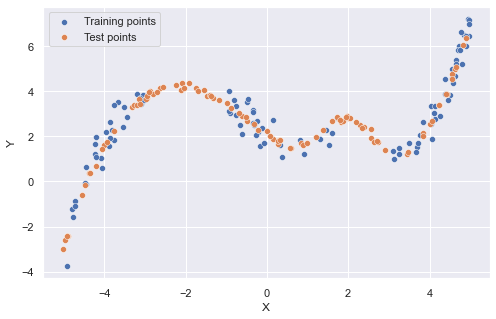

In [37]:
fig = plt.figure(figsize=(8,5))
sns.scatterplot(x=train_dataset[:,0], y=train_dataset[:,1], label='Training points')
sns.scatterplot(x=test_dataset[:,0], y=test_dataset[:,1], label='Test points')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
fig.savefig("images/regr_data_plot.pdf") 

## Network definition

In [38]:
class Net(nn.Module):
    """
    Network class with customizable architecture

    """
    def __init__(self, N_in=1, N_hid=[10], N_out=1, act_func = nn.Sigmoid(), dropout = 0, act_output = False):
        """
        Initialization function for the network
        
        Parameters
        ----------
        
        N_in: Input layer size
        N_hid: Array containing sizes of hidden layers
        N_out: Output layer size
        act_func: Activation function
        dropout: Activate dropout between hidden layers
        act_output: Activation function on the output
        
        """
        super(Net,self).__init__()
        
        # defining internal variables
        self.N_in=N_in                # number of input neurons  
        self.N_hid=N_hid              # sizes of hidden layers
        self.N_out=N_out              # size of output layer  
        self.act_func = act_func      # activation function 
        self.dropout = dropout        # dropout value  
        self.act_output = act_output  # boolean for activation function on the output neuron  
        
        self.hid_layers = []
        self.hid_layers.append(nn.Linear(in_features=N_in, out_features=N_hid[0]))

        # appending hidden layers 
        for i in range(1,len(N_hid)):
            self.hid_layers.append(nn.Linear(in_features=N_hid[i-1], out_features=N_hid[i]))
        
        # creating output layer
        self.out_layer = nn.Linear(in_features=N_hid[-1], out_features=N_out)
            
    def forward(self, x):
        # forward calculations of layers output
        for layer in self.hid_layers:
            x = self.act_func(layer(x))
            if self.dropout>0:
                x = nn.Dropout(self.dropout)(x)

        x = self.out_layer(x)
        
        if self.act_output == True:
            x = self.act_func(x)
        return x

## Network initialization

In [39]:
# instantiating the network and wrapping with the NeuralNetRegressor object of skorch to allorw training
torch.manual_seed(0)
network = Net(N_in=1,           
            N_hid=[167, 32, 187], 
            N_out=1,            
            dropout=0,          
            act_func=nn.ReLU(), 
            act_output=False,)  

# skorch wrapper for training purposes with 80-20 automatic random splitting of the dataset
net_skorch = NeuralNetRegressor(
            module=network,         
            criterion= nn.MSELoss,                                      # loss function
            max_epochs=450,                                             # maximum training epochs
            optimizer__lr = 0.2,                                        # learning rate
            optimizer = optim.Adam,                                     # optimizer
            batch_size = 40,                                            # batch_size
            optimizer__weight_decay	= 3e-4,                             # L2 regularization
            callbacks = [callbacks.EarlyStopping(monitor='valid_loss',  # early stopping callback
                             patience=100, threshold=0.1)],
            verbose=0,
)

## Training

In [40]:
net_skorch.fit(train_dataset[:,0].reshape([-1,1]), train_dataset[:,1].reshape([-1,1]))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (act_func): ReLU()
    (out_layer): Linear(in_features=187, out_features=1, bias=True)
  ),
)

## Loss plot

In [41]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

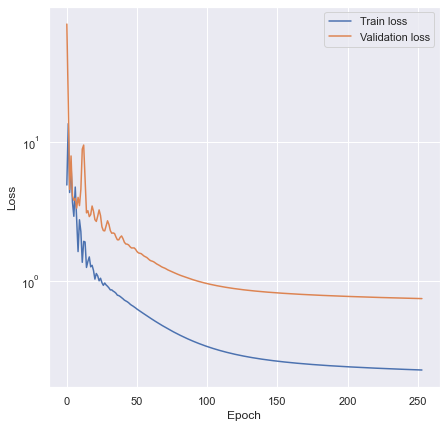

In [42]:
# losses plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
sns.lineplot(x=np.arange(len(train_loss)),y=val_loss, label='Validation loss',markers=True, ax=ax)

ax.set_yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("images/regr_loss_plot.pdf") 


## Results

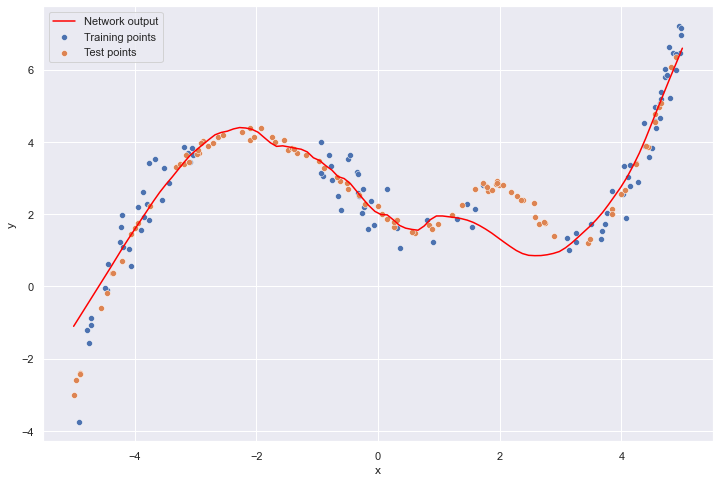

In [43]:
# convert x_vec and y_vec to numpy one dimensional arrays
x_vec = torch.tensor(np.linspace(5,-5,100).reshape(-1,1),dtype=torch.float32)
y_vec = net_skorch.predict(x_vec)

# plot output
fig = plt.figure(figsize=(12,8))
sns.lineplot(x=np.linspace(5,-5,100), y=y_vec.flatten(), label='Network output', color="Red")
sns.scatterplot(x=train_dataset[:,0], y=train_dataset[:,1], label='Training points')
sns.scatterplot(x=test_dataset[:,0], y=test_dataset[:,1], label='Test points')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

fig.savefig("images/regr_fit_plot.pdf") 


In [44]:
# calculation of the test loss
print(f"Validation loss: {net_skorch.get_loss(torch.tensor(net_skorch.predict(test_dataset[:,0].reshape(-1,1)).flatten()),test_dataset[:,1]):.2f}")


Validation loss: 0.51


## Layer activations

In [45]:
# adding a hook to record activations
activations = []

def activation_hook(module, input, output):
    activations.append(output.detach())

# adding a hook for each layer
for layer in network.hid_layers:
    layer.register_forward_hook(activation_hook)

network.out_layer.register_forward_hook(activation_hook)

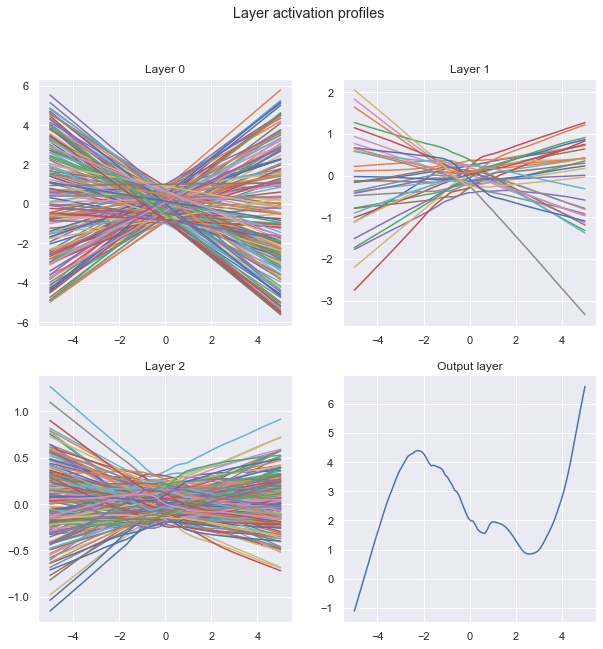

In [46]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
network(x_vec.clone().detach().unsqueeze(1))
plt.suptitle("Layer activation profiles")

# using previously computed layer activation profiles and plotting them
for i,act,ax in zip(np.arange(4),activations,axes.flatten()):
    ax.plot(x_vec,act.reshape(act.shape[0],act.shape[2]))
    if i!=3:
        ax.set_title(f"Layer {i}")
    else:
        ax.set_title("Output layer")

fig.savefig("images/regr_act_plot.pdf") 


## Weights visualization

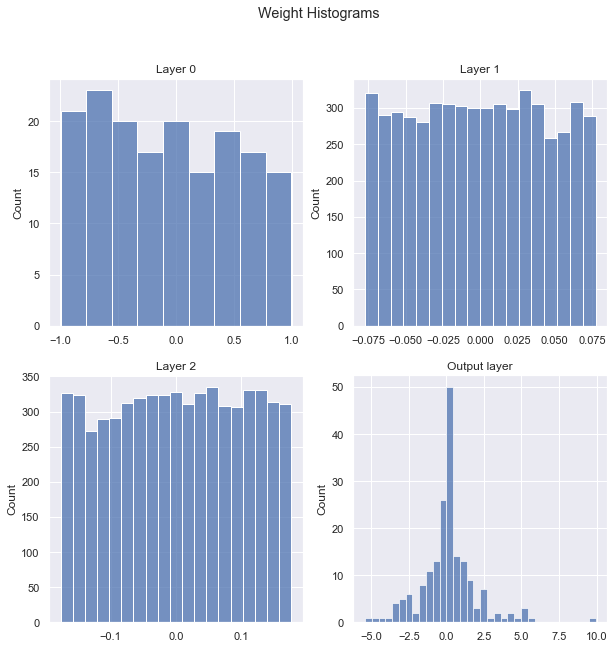

In [47]:

fig, axes = plt.subplots(2,2, figsize = (10,10))
plt.suptitle("Weight Histograms")
layer_list = network.hid_layers.copy()
layer_list.append(network.out_layer)

# plotting the weights for each layer
for i,layer,ax in zip(np.arange(4),layer_list,axes.flatten()):
    # expanding the layers content in order to plot the weights
    sns.histplot(layer.weight.detach().numpy().flatten(),ax=ax)
    if i!=3:
        ax.set_title(f"Layer {i}")
    else:
        ax.set_title("Output layer")

fig.savefig("images/regr_weight_plot.pdf") 


## Random GridSearch


In [ ]:
# params = {
#     'optimizer__lr': np.arange(0.001,1,0.009),
#     'module__N_hid' : [[i,j,k] for i in np.arange(2,200,5) for j in np.arange(2,200,5) for k in np.arange(2,200,5)],
#     'optimizer__weight_decay' : np.arange(1e-3,1e-5,5e-5)
# }

# rs = RandomizedSearchCV(estimator = net_skorch, 
#                    param_distributions = params, 
#                    cv = KFold(n_splits=5,shuffle=True), n_iter = 2000)
# rs.fit(train_dataset[:,0].reshape([-1,1]), train_dataset[:,1].reshape([-1,1]), scoring = "neg_squared_average")
# print(rs.best_score_, rs.best_params_)

In [81]:
## Gridsearch result for plotting

# pd.DataFrame(rs.cv_results_).to_csv("Random_Regression.csv")
df = pd.read_csv("Random_Regression.csv").sort_values("mean_test_score")

# Returning only the 5 most valuable results
df.tail(5)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__lr,param_module__N_hid,param_max_epochs,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1171,1171,1.224502,0.210446,0.001340,0.000089,0.00006,0.208,"[107, 167, 162]",150,10,{'optimizer__weight_decay': 6.000000000000016e...,-3.285861,-4.039732,-2.754476,-4.254048,-4.958928,-3.858609,0.767728,5
1486,1486,2.527195,2.383707,0.001403,0.000074,0.00035,0.064,"[122, 2, 112]",500,10,{'optimizer__weight_decay': 0.0003500000000000...,-5.459361,-3.233978,-2.864063,-2.757775,-4.706860,-3.804407,1.082439,4
1553,1553,1.061712,0.328614,0.001307,0.000083,0.00053,0.640,"[192, 42, 37]",350,10,{'optimizer__weight_decay': 0.0005300000000000...,-3.258700,-2.543730,-4.362576,-3.811235,-5.018454,-3.798939,0.857025,3
1181,1181,0.043845,0.002378,0.000967,0.000027,0.00071,0.505,"[62, 102, 17]",10,45,"{'optimizer__weight_decay': 0.00071, 'optimize...",-2.739834,-3.457723,-1.645509,-4.122069,-6.715153,-3.736058,1.700843,2
808,808,1.779372,1.274328,0.001375,0.000244,0.00025,0.199,"[62, 147, 47]",450,15,{'optimizer__weight_decay': 0.0002500000000000...,-3.090744,-2.916828,-3.761834,-3.611668,-4.737391,-3.623693,0.639257,1


# Classification task

## Dataset

In [48]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)) ])

# loading train and test dataset applying transformations to the train dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transformations)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

# defining input and label dataset for training
input_data = train_dataset.data.type(torch.float32).reshape(60000,1,28,28)
label_data = train_dataset.targets.type(torch.int64).reshape(60000)

test_input_data = test_dataset.data.type(torch.float32).reshape(10000,1,28,28)
test_label_data = test_dataset.targets.type(torch.int64).reshape(10000)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

## Models definition

In [49]:
class ConvolutionalNet(nn.Module):
    """
    Convolutional network with customizable architecture

    """
    def __init__(self,  dropout=0, act_func=nn.ReLU(), linear_size = 100, conv0_size = 10, conv1_size = 20):
        """
        Initialization function for the network
        
        Parameters
        ----------
        dropout: dropout probability for the function applied after the second convolutional layer
        act_func: activation function for the convolutional layers 
        linear_size: size of the linear layer of the model
        conv0_size: number of channels of the first convolutional layer
        conv1_size: number of channels of the second convolutional layer

        """
        super(ConvolutionalNet,self).__init__()
        
        # first layer settings
        self.conv0_size = conv0_size
        self.kernel_size0 = 2
        self.padding0 = 1
        self.stride0 = 2
        self.dilation0 = 1

        # second layer settings
        self.conv1_size = conv1_size     
        self.kernel_size1 = 3
        self.padding1 = 1
        self.stride1 = 2
        self.dilation1 = 1

        # linear layer settings        
        self.linear_size = linear_size
        self.act_func = act_func
        self.final_func = nn.Softmax(dim=1)
        self.N_out= 10

        # dropout settings
        self.dropout = dropout
        self.dropout_func = nn.Dropout(self.dropout)

        # network instantiation
        self.conv0 = nn.Conv2d(1,self.conv0_size,kernel_size=self.kernel_size0,padding=self.padding0,stride=self.stride0,dilation=self.dilation0) #(1,28,28) -> (self.conv0_size,15,15)
        
        self.conv1 = nn.Conv2d(self.conv0_size,self.conv1_size,kernel_size=self.kernel_size1,padding=self.padding1,stride=self.stride1,dilation=self.dilation1) #(self.conv0_size,15,15) -> (self.conv1_size,8,8)

        self.lin_layer = nn.Linear(in_features=self.conv1_size*8*8, out_features=self.linear_size)          
        self.out_layer = nn.Linear(in_features=self.linear_size, out_features=self.N_out)
        
    def forward(self, x):
        
        # first convolutional layer
        x = self.conv0(x)
        x = self.act_func(x)

        # second convolutional layer  
        x = self.conv1(x)
        x = self.act_func(x)

        # dropout function
        x = self.dropout_func(x)

        # linear layer
        x = x.view(-1,self.conv1_size*8*8)
        x = self.lin_layer(x)
        x = self.act_func(x)

        # output layer
        x = self.out_layer(x)
        
        x = self.final_func(x)
        return x

## Model implementation

In [50]:
torch.manual_seed(0)
classifierNet = ConvolutionalNet(act_func=nn.ReLU(), linear_size=120, conv0_size = 10, conv1_size = 20, dropout=0.2)

net_skorch = NeuralNetClassifier(
            module=classifierNet,   
            criterion= nn.CrossEntropyLoss,                             # loss calculation function
            max_epochs=20,                                              # max number of epochs
            optimizer__lr = 1e-3,                                       # learning rate
            optimizer = optim.Adam,                                     # optimizer 
            batch_size = 1000,                                          # batch size
            # optimizer__weight_decay=1e-5,                             # L2 Regularization          
            callbacks = [callbacks.EarlyStopping(monitor='valid_loss',  # callback for early stopping   
                                 patience=100, threshold=0.005)],     
            # verbose = 0
)

## Model fitting

In [ ]:
net_skorch.fit(input_data,label_data)

## Loss plotting

In [52]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

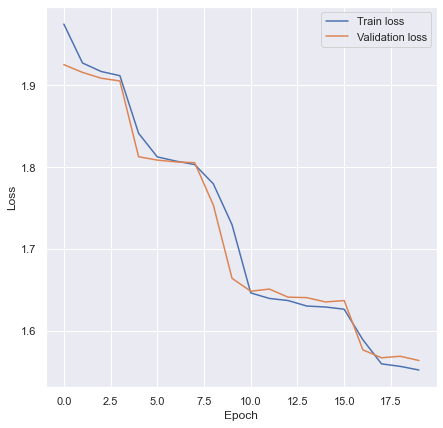

In [13]:
# Plot losses
fig, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
sns.lineplot(x=np.arange(len(train_loss)),y=val_loss, label='Validation loss',markers=True, ax=ax)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig("images/conv_loss_plot.pdf") 


## Confusion Matrix

In [14]:
# estimating the prediction of the network
y_pred = net_skorch.predict(test_input_data)

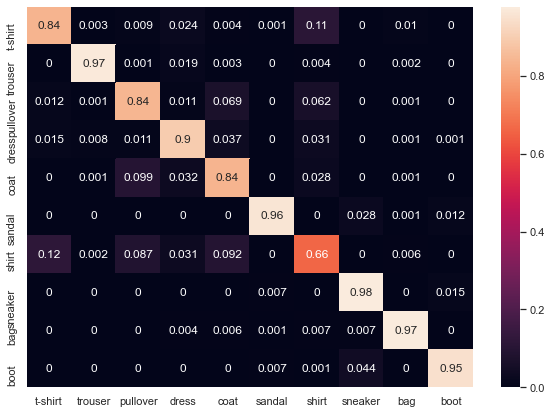

In [15]:
# plotting the confusion matrix for the prediction
fig, ax = plt.subplots(1,1,figsize = (10,7))
c_matrix = confusion_matrix(test_label_data.detach().numpy(),y_pred)
sns.heatmap(c_matrix/c_matrix.astype(float).sum(axis=1) ,annot=True)

ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

fig.savefig("images/conv_cmat_plot.pdf") 

In [16]:
# single class accuracies
print("Accuracies for the 10 classes: ", c_matrix.diagonal()/c_matrix.sum(axis=1))
# total accuracy
print(f"Total accuracy: {(c_matrix.diagonal()/c_matrix.sum(axis=1)).mean():.2f}")

Accuracies for the 10 classes:  [0.839 0.971 0.844 0.896 0.839 0.959 0.664 0.978 0.975 0.948]
Total accuracy: 0.89


## Weight visualization

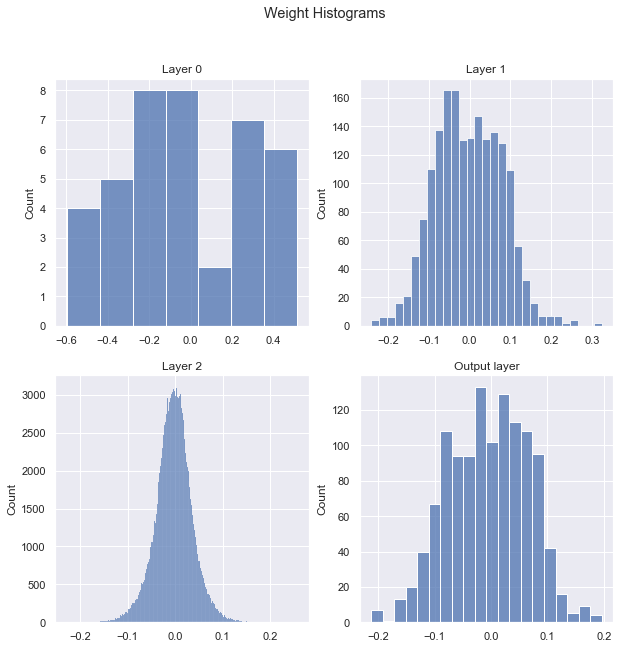

In [54]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
layers = [classifierNet.conv0,classifierNet.conv1,classifierNet.lin_layer,classifierNet.out_layer]
plt.suptitle("Weight Histograms")

# plotting the weights for each layer
for i,layer,ax in zip(np.arange(4),layers,axes.flatten()):
    sns.histplot(layer.weight.detach().numpy().flatten(), ax=ax)
    if i!=3:
        ax.set_title(f"Layer {i}")
    else:
        ax.set_title("Output layer")

fig.savefig("images/conv_weight_plot.pdf") 


## Feature Maps

In [31]:
# creating a feature map for a shirt sample
no_of_layers=2
conv_layers=list(classifierNet.children())[3:5]

image = input_data[label_data == 6][0].reshape(1,1,28,28)

results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


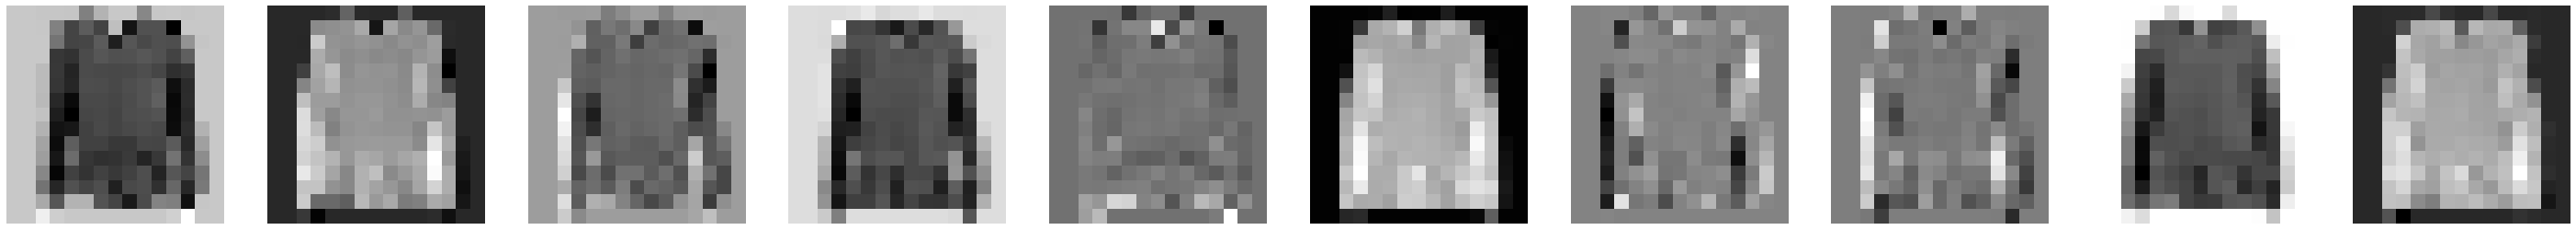

Layer  2


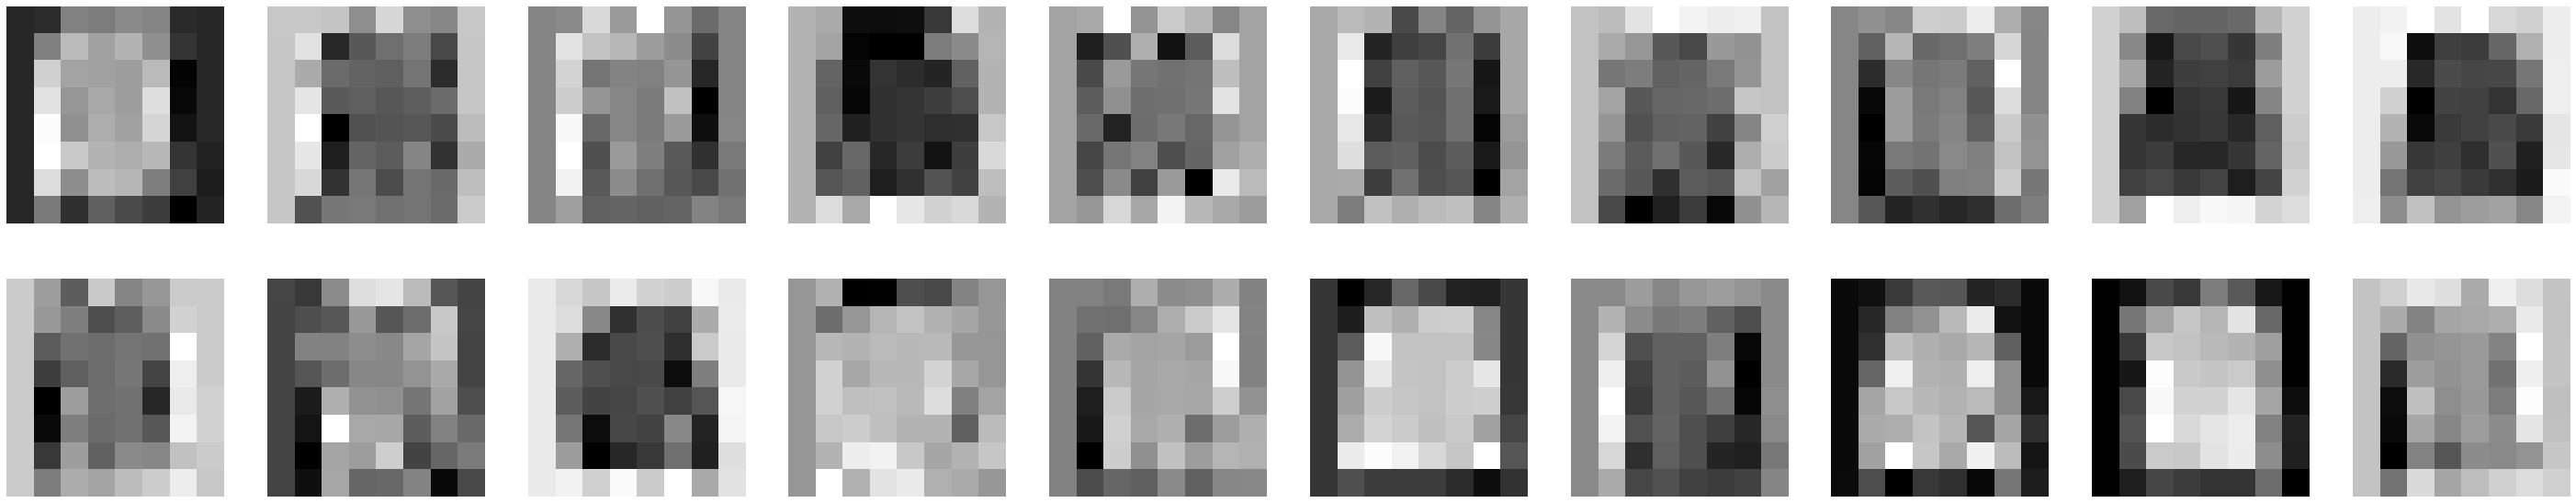

In [55]:
# plotting the layer outputs 
for num_layer in range(len(outputs)):
    fig = plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        plt.subplot(2, 10, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

    fig.savefig("images/conv_feat_plot"+str(i)+".pdf") 


## Weigth visualization

In this section it is possible to visualize the weight for the first layer, since it takes on a single channel. The low dimension of the kernels do not allow further analysis on the kernel functions. 

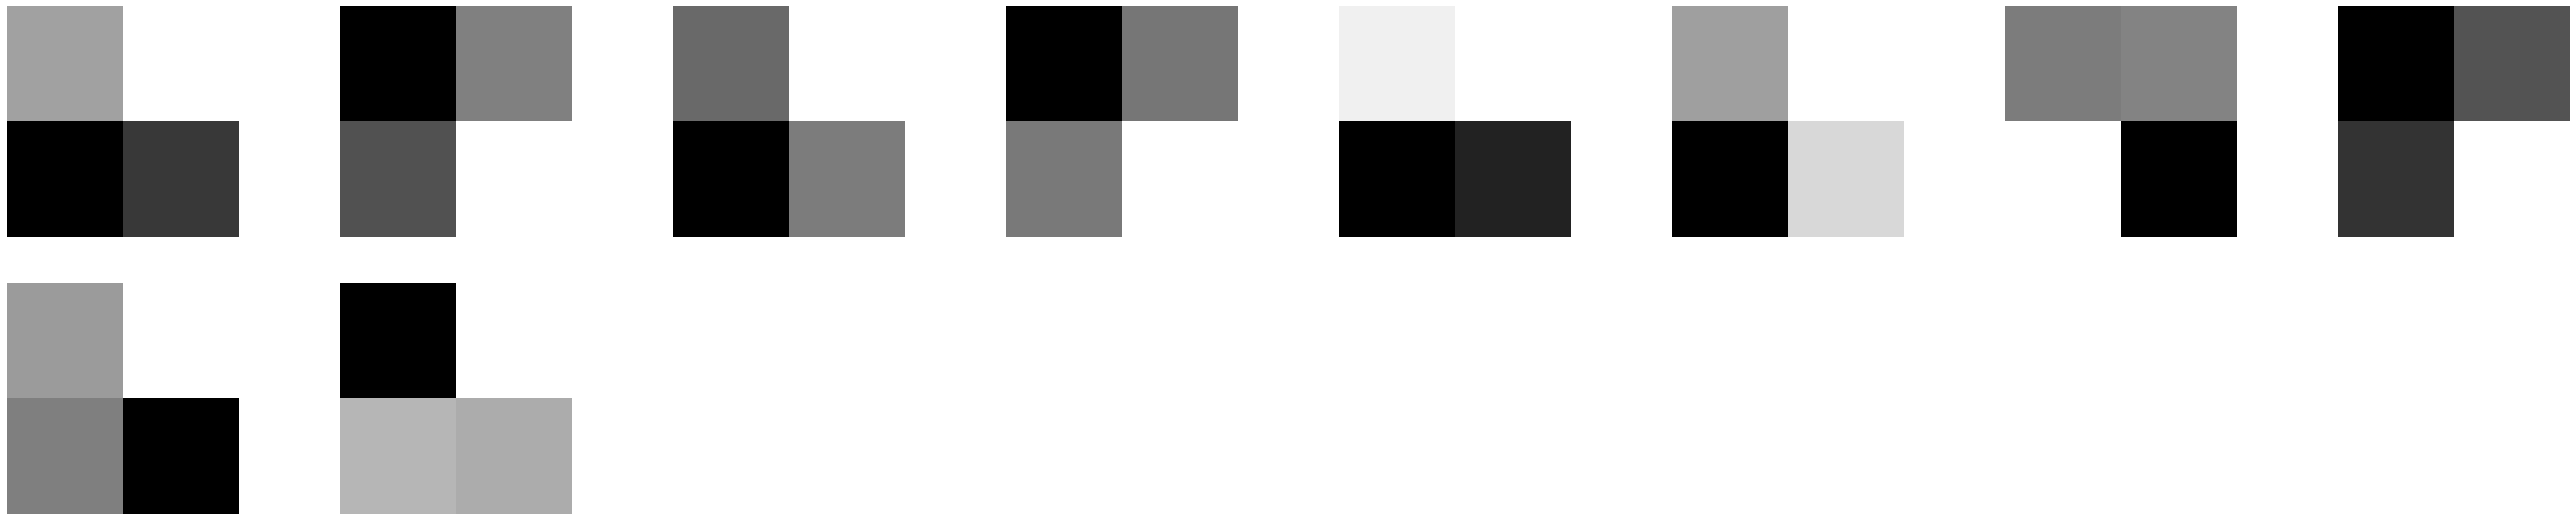

In [213]:
for layer in [conv_layers[0]]:
    fig = plt.figure(figsize=(50, 10))
    for i,channel in enumerate(layer.weight.data):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(channel[0], cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    fig.savefig("images/conv_wvisual_plot.pdf") 


## Random Gridsearch

In [214]:
# params = {
#     'lr': np.arange(0.001,0.1,0.009),
#     'batch_size': list(range(100,30000,500)),
#     'module__dropout' : np.arange(0.1,1,0.1),
#     'module__linear_size' : np.arange(1,50,10,dtype=int),
#     'module__conv0_size' : np.arange(1,50,10,dtype=int),
#     'module__conv1_size' : np.arange(1,50,10, dtype=int)
# }

# rs = RandomizedSearchCV(estimator = net_skorch, 
#                    param_distributions = params, 
#                    cv = 5, n_iter = 200)
                   
# rs.fit(input_data, label_data)
# print(rs.best_score_, rs.best_params_)

In [17]:
df = pd.read_csv("Random_Classification.csv").sort_values("mean_test_score")
df.tail(5)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__linear_size,param_module__dropout,param_module__conv1_size,param_module__conv0_size,param_lr,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
139,139,106.547585,0.947103,0.494603,0.007710,21,0.6,31,41,0.064,600,"{'module__linear_size': 21, 'module__dropout':...",0.815750,0.762583,0.869583,0.810917,0.703250,0.792417,0.056004,5
155,155,41.225464,0.600999,0.238100,0.027135,41,0.1,11,11,0.082,1600,"{'module__linear_size': 41, 'module__dropout':...",0.811417,0.803333,0.814917,0.830167,0.725083,0.796983,0.036989,4
96,96,86.656506,0.333029,0.398013,0.039527,41,0.6,41,21,0.082,7100,"{'module__linear_size': 41, 'module__dropout':...",0.699583,0.759500,0.878583,0.807833,0.865333,0.802167,0.066641,3
61,61,48.145947,0.086620,0.241600,0.023999,41,0.2,21,11,0.010,3600,"{'module__linear_size': 41, 'module__dropout':...",0.872417,0.811833,0.786083,0.749500,0.791833,0.802333,0.040417,2
26,26,46.225161,0.333087,0.222901,0.022355,11,0.6,21,11,0.073,1600,"{'module__linear_size': 11, 'module__dropout':...",0.801167,0.784500,0.859667,0.863583,0.799833,0.821750,0.033104,1
